Basado en: https://github.com/fferegrino/cf-ml/blob/main/quien-esta-hablando/quien-esta-hablando-complete.ipynb 

In [2]:
import string

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

from unidecode import unidecode


In [3]:
# Descarga información necesaria para el pre-procesamiento
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrador\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [7]:
dialogs = pd.read_csv('dialogos.csv', index_col=0)
dialogs['speaker'] = np.where(dialogs['speaker'] == 'amlo','politico','medico')
dialogs.sample(10)

,speaker,dialog,length
78580,politico,"¡Mexicanas, mexicanos!:",23
151077,politico,"Bueno, una pues. ¿Quién? A ver tú, mientras bu...",62
60154,medico,"Porque también hay un elemento de pragmatismo,...",241
24325,politico,Pues que se haga la investigación. Qué bien qu...,126
152187,medico,Continuaremos.,14
30589,medico,En este momento tenemos en promedio 50 por cie...,271
57673,medico,"Y como sabemos, muy pronto estas cinco persona...",221
41878,medico,"El colega que está aquí en frente, usted y Lilia.",49
104089,politico,¿En ese entonces qué dijeron? Que no íbamos a ...,353
12325,politico,Otro dato importante es cómo ha ido disminuyen...,245


### Métrica de elección: Accuracy

# Análisis Exploratorio de Datos

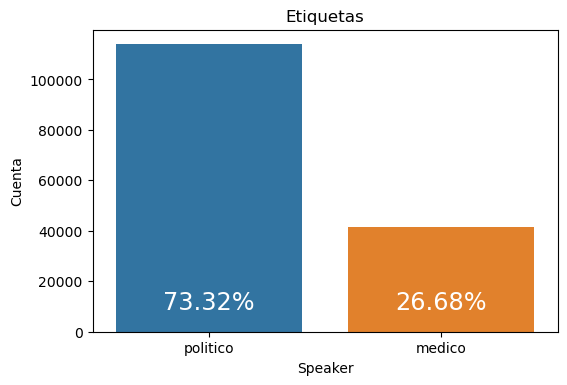

In [5]:
fig = plt.figure(dpi=100)
ax = fig.gca()
sns.countplot(x='speaker', data=dialogs, ax=ax)
ax.set_title("Etiquetas")
ax.set_xlabel("Speaker")
ax.set_ylabel("Cuenta")

percentages = (dialogs["speaker"].value_counts() / len(dialogs)).to_dict()
xs = {label.get_text():idx for idx, label in enumerate(ax.get_xticklabels())}
for label, pct in percentages.items():
#    x = labels[label].get_x()
    ax.text(xs[label],9000, f"{pct:0.2%}", ha='center', fontsize="xx-large", c="white")
    pass

### Longitud del Texto

<AxesSubplot:xlabel='length', ylabel='speaker'>

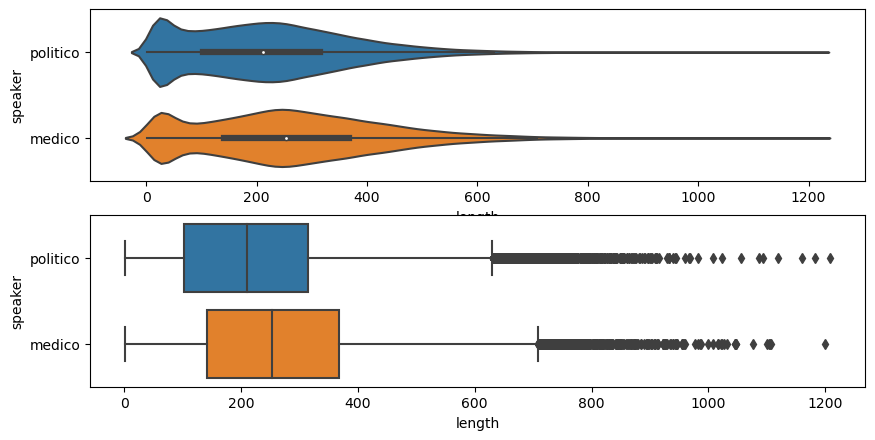

In [6]:
lengths = dialogs["dialog"].str.len()

dialog_lenghts = pd.DataFrame({
    "speaker": dialogs["speaker"],
    "length": lengths
})
fig, (ax1, ax2) = plt.subplots(2, 1, dpi=100, figsize=(10,5))

sns.violinplot(y="speaker" , x="length", data=dialog_lenghts, ax=ax1)
sns.boxplot(y="speaker" , x="length", data=dialog_lenghts, ax=ax2)

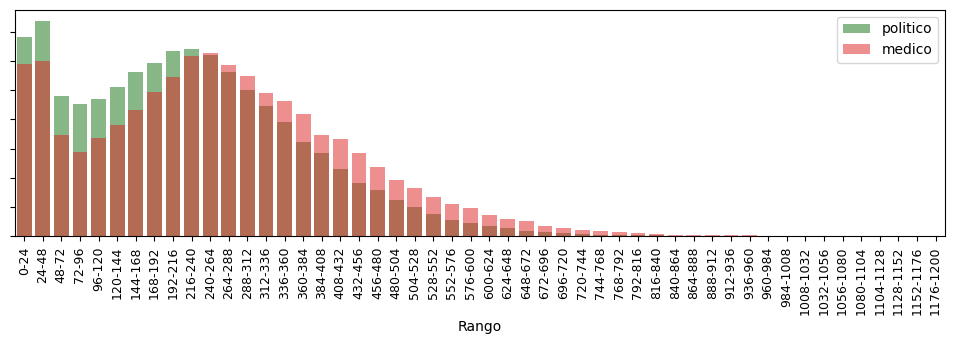

In [7]:
fig = plt.figure(dpi=100, figsize=(12, 3))
ax = fig.gca()


for label, color in [("politico", "green"), ("medico", "red")]:
    lengths = dialog_lenghts[dialog_lenghts["speaker"] == label]
    values, bins = np.histogram(lengths["length"], range=(0, 1200), bins=50)
    y = (bins[1:] + bins[:-1]) / 2
    sns.barplot(x=y, y=values/ len(lengths), label=label, color= color, ax=ax, alpha=0.5 )
ax.set_xticklabels([f"{int(_y)}-{int(_x)}" for _x,_y in zip(bins[1:], bins[:-1])], rotation=90, fontsize=9)
ax.set_yticklabels([])
ax.set_xlabel("Rango")
ax.legend()

# Dividir el dataset

In [5]:
from sklearn.model_selection import train_test_split

In [8]:
rest, test = train_test_split(dialogs, test_size=0.2, stratify=dialogs['speaker'])

train, val = train_test_split(rest, test_size=0.2, stratify=rest['speaker'])

len(train), len(val), len(test)


(99524, 24881, 31102)

In [9]:
dialogs_train = train["dialog"]
dialogs_val = val["dialog"]
dialogs_test = test["dialog"]

target_train = train["speaker"]
target_val = val["speaker"]
target_test = test["speaker"]

target_train.head

<bound method NDFrame.head of 98810     politico
130762      medico
7541        medico
20968       medico
130643    politico
            ...   
105559    politico
71282     politico
22192     politico
24515     politico
106761    politico
Name: speaker, Length: 99524, dtype: object>

# Feature Engineering

### Etiqueta

In [10]:
train_y = np.where(target_train == "politico", 1, 0)
val_y = np.where(target_val == "politico", 1, 0)
test_y = np.where(target_test == "politico", 1, 0)

### Texto

In [15]:
dialogs_train.values

array(['Bueno, como se sabe, ya hubo una resolución de la Suprema Corte para que sean las UMAS las que sirvan de unidad para definir lo de las jubilaciones.',
       'En esta pandemia yo reivindico la importancia que tiene la integración de las familias. Si ustedes ven el número de fallecidos y las edades, van a encontrar que los más ancianitos se han protegido a diferencia de otros lugares y sí, tenemos que seguir cuidándonos.',
       'Y van a seguir recibiendo lo que era el Procampo, van a seguir recibiendo ese apoyo, ahora se llama Producción para el Bienestar, pero van a seguir recibiendo ese apoyo.',
       ..., 'Adelante.',
       'El gobernador Carlos Mendoza está haciendo un buen trabajo, de manera especial en lo que importa mucho: la seguridad pública. Es notorio el que haya menos violencia en Baja California Sur.',
       'Aquí, en la ciudad, se produce el 23 por ciento de toda la riqueza que se genera en el país, de modo que hay una inmensa reserva de energía que está siend

### Tokenización

In [11]:
from nltk.tokenize.toktok import ToktokTokenizer


tk_tokenizer = ToktokTokenizer()

In [12]:
example_sentence = dialogs_train.iloc[80567]
print(example_sentence)
tokens = tk_tokenizer.tokenize(example_sentence)
print(" # ".join(tokens))

Con los ahorros por no permitir la corrupción y también con los ahorros por no permitir los lujos en el gobierno.
Con # los # ahorros # por # no # permitir # la # corrupción # y # también # con # los # ahorros # por # no # permitir # los # lujos # en # el # gobierno # .


In [15]:
from nltk.corpus import stopwords
from unidecode import unidecode

sp_stopwords = stopwords.words("spanish")
sp_punctuation = string.punctuation + '¿¡'

sp_punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~¿¡'

In [17]:
not_wanted = set((unidecode(word) for word in sp_stopwords)) | set(sp_punctuation)

def tokenize(sentence):
    clean = []
    clean_sentence = unidecode(sentence)
    for token_ in tk_tokenizer.tokenize(clean_sentence):
        token = token_.lower()
        if token in not_wanted:
            continue
        clean.append(token)
    return clean


In [18]:
tokens = tokenize(example_sentence)
print(example_sentence)
print()
tokens = tokenize(example_sentence)
print(" # ".join(tokens))

Con los ahorros por no permitir la corrupción y también con los ahorros por no permitir los lujos en el gobierno.

ahorros # permitir # corrupcion # ahorros # permitir # lujos # gobierno


### One-Hot Encoding (Vectorización)
El siguiente paso es convertir esa secuencia de tokens limpios a un conjunto de números. Para esto existen todavía más opciones, pero vamos nuevamente a comenzar con una más sencilla. Digamos que vamos a crear una tabla enorme en donde las columnas serán todos y cada uno de los tokens y cada una de las filas va a ser cada uno de los ejemplos que tenemos a nuestro alcance.

Entonces, lo que vamos a hacer es ir oración por oración y token por token, cuando encontremos un token en una oración vamos a poner un 1 en esa fila y en esa columna

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizador_ejemplo = CountVectorizer(binary=True, analyzer=tokenize, max_features=4000)

In [20]:
ejemplos = [
    "viva mexico paisanos en setpiembre",
    "en mexico hay inundaciones de viva voz"
]
vectors = vectorizador_ejemplo.fit_transform(ejemplos)

vocabulary = vectorizador_ejemplo.vocabulary_
columns = [token for token, _ in sorted(vocabulary.items(), key=lambda item: item[1])]
pd.DataFrame(vectors.todense(), columns=columns, index=[1, 2])

,inundaciones,mexico,paisanos,setpiembre,viva,voz
1,0,1,1,1,1,0
2,1,1,0,0,1,1


#### Entrenar vectorizador

In [38]:
vectorizador_real = CountVectorizer(binary=True, analyzer=tokenize, max_features=5000)
vectorizador_real.fit(dialogs_train)

train_x = vectorizador_real.transform(dialogs_train)
val_x = vectorizador_real.transform(dialogs_val)
test_x = vectorizador_real.transform(dialogs_test)

### Modelado

In [39]:
from sklearn.linear_model import LogisticRegression

In [40]:
lr = LogisticRegression(max_iter=1000, class_weight="balanced")

In [41]:
# Entrenando modelo
lr.fit(train_x, train_y) 

LogisticRegression(class_weight='balanced', max_iter=1000)

In [42]:
train_pred = lr.predict(train_x)  # Para diagnosticar overfitting
val_pred = lr.predict(val_x)  # Para decidir cambios sobre el modelo

#### Revisando las métricas establecidas

In [43]:
from sklearn.metrics import accuracy_score, classification_report

In [44]:
training_accuracy = accuracy_score(train_y, train_pred)
validation_accuracy = accuracy_score(val_y, val_pred)

print(f"Training accuracy:   {training_accuracy:0.2%}")
print(f"Validation accuracy: {validation_accuracy:0.2%}")

Training accuracy:   96.92%
Validation accuracy: 95.72%


In [45]:
print(classification_report(train_y, train_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94     26552
           1       0.98      0.97      0.98     72972

    accuracy                           0.97     99524
   macro avg       0.96      0.97      0.96     99524
weighted avg       0.97      0.97      0.97     99524



#### Evaluando desempeño en el conjunto de prueba

In [46]:
test_pred = lr.predict(test_x)
test_accuracy = accuracy_score(test_y, test_pred)

print(f"Test accuracy:   {test_accuracy:0.2%}")

Test accuracy:   95.65%


## Evaluando una oración propia

In [63]:
#oración = "En este gobierno los médicos hacen lo posible para controlar la pandemia, vacúnate y quédate en casa, las investigaciones respaldan la desición de vacunarse"
oración = "Hay que ganar las elecciones"
own_x = vectorizador_real.transform([oración])
result = lr.predict(own_x)
medico, politico = lr.predict_proba(own_x).squeeze() * 100
print(f"{medico:05.2f}% – Médico\n{politico:05.2f} - Político")

08.51% – Médico
91.49 - Político
